In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler

In [63]:
# 1857년 노동 계급 벨기에 가정의 가구 소득 및 식품 소비 데이터(엥겔 데이터)
engel = sm.datasets.engel.load_pandas().data

In [64]:
engel.head(2)

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667


In [65]:
# 데이터 표준화
scaler = StandardScaler()
scaler.fit(engel)
engel_scaled = scaler.transform(engel)

engel_scaled = pd.DataFrame(engel_scaled, columns = engel.columns )

In [66]:
y = engel_scaled['income'].values

In [67]:
X = engel_scaled['foodexp']
X = sm.add_constant(X)
X = X.values

C:\Users\sypar\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [68]:
n = X.shape[0]   # the number of data
p = X.shape[1]   # the number of parameters
print(n, p)

235 2


In [69]:
y = y.reshape(n, 1)
beta_T= np.ones((p, 1))

In [9]:
# X = n*p
# y = n*1
# beta_T = p*1

In [13]:
def G(X, y, beta_T, tau, lambda_value):
    # 행렬 차수
    n, p = X.shape
    
    # 벡터 계산
    X_beta = X @ beta_T   # (n*p) * (p*1)  => (n*1)
    
    # 잔차
    res = y - X_beta     # (n*1) - (n*1)
    
    # QR loss term
    loss = [tau*i if i >=0 else (tau-1)*i for i in res]
    first_term = sum(loss)/n                
    
    # lambda absolute beta term
    second_term = lambda_value*sum(beta_T)
    
    return first_term + second_term

In [14]:
G(X, y, beta_T, 0.75, 1)

array([2.26477037])

In [15]:
def H(beta_T, lambda_value, gamma_value, a_value):
    # MCL - lambda*sum of |beta|
    h_beta = [i**2/(2*a_value) 
              if 0 <= abs(i) < a_value*(lambda_value - gamma_value)
              else (lambda_value - gamma_value)*abs(i) - a_value*(lambda_value**2 - gamma_value**2)/2 
              for i in beta_T]
    
    return sum(h_beta)

In [17]:
H(beta_T, 2, 1, 2)

array([0.5])

In [18]:
def G_subgradient_j(X, y, beta_T, tau, lambda_value, j):
    # 행렬 차수
    n, p = X.shape
    
    # 벡터 계산
    X_beta = X @ beta_T   # (n*p) * (p*1)  => (n*1)
    
    # 잔차
    res = y - X_beta     # (n*1) - (n*1)
    
    # subgradient
    loss_subgradient = [-tau * X[i, j] if res[i] > 0 
                        else (1-tau) * X[i, j] if res[i] < 0 
                        else -1*random.uniform(tau-1, tau) * X[i, j] 
                        for i in range(n)]
    
    first_term = sum(loss_subgradient)/n
    
    
    second_term = [lambda_value if beta_T[j] > 0 
                    else -1 * lambda_value if beta_T[j] < 0
                    else random.uniform(-1,1) * lambda_value]
    
    return first_term + second_term

In [19]:
G_subgradient_j(X, y, beta_T, 0.8, 2, 1)

array([1.97774423])

In [20]:
def H_subgradient_j(beta_T, lambda_value, gamma_value, a_value, j):
    # subgradient
    beta_subgradient = [beta_T[j]/a_value 
                        if 0 <= abs(beta_T[j]) < a_value * (lambda_value - gamma_value)
                        else (lambda_value - gamma_value) * beta_T[j] / abs(beta_T[j])]
    
    return beta_subgradient

In [21]:
H_subgradient_j(beta_T, 2, 1, 2, 1)

[array([0.5])]

In [23]:
def coordinate_descent(X, y, beta_T, tau, lambda_value, gamma_value, a_value, alpha = 0.03, num_iters = 10):
    # 행렬 차수
    n, p = X.shape
    
    loss_history = np.zeros(shape = (num_iters, 1))
    beta_history = np.zeros(shape = (num_iters, p))
    
    # coordinate_descent 
    for i in range(num_iters):
        for j in range(p):
            subgradient = G_subgradient_j(X, y, beta_T, tau, lambda_value, j) + H_subgradient_j(beta_T, lambda_value, gamma_value, a_value, j)
            
            beta_T[j] = beta_T[j] - alpha*subgradient
            
            # saving values
            beta_history[i, j] = beta_T[j]
            loss_history[i] = G(X, y, beta_T, tau, lambda_value) + H(beta_T, lambda_value, gamma_value, a_value)
            
    return beta_T, beta_history, loss_history  

In [34]:
beta_T= np.ones((p, 1))

In [35]:
beta_T, beta_history, loss_history = coordinate_descent(X, y, beta_T, 0.75, 2, 1, 1, 0.03, 20)

In [36]:
beta_history

array([[ 0.90275532,  0.91066767],
       [ 0.80842798,  0.82419003],
       [ 0.71769642,  0.74111829],
       [ 0.62981446,  0.66128823],
       [ 0.54546258,  0.58465491],
       [ 0.46479019,  0.51241493],
       [ 0.38717627,  0.44304079],
       [ 0.31265673,  0.37688719],
       [ 0.24152171,  0.31387938],
       [ 0.17392499,  0.25361716],
       [ 0.10963278,  0.19561434],
       [ 0.04790762,  0.13967818],
       [-0.01119982,  0.08554562],
       [ 0.0526149 ,  0.03299513],
       [-0.0065061 , -0.01783969],
       [ 0.05704014,  0.05285778],
       [-0.00234127,  0.00142707],
       [ 0.06082471, -0.04849267],
       [ 0.00171274,  0.0232884 ],
       [-0.0552429 , -0.02709869]])

In [38]:
beta_history[0,0]

0.9027553191489361

In [39]:
len(beta_history)

20

In [3]:
x = np.linspace(0,1,40)
noise = 1*np.random.uniform(  size = 40)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = (y + noise).reshape(-1,1)
y_noise = y_noise - y_noise.mean()
X = np.vstack((2*x,x**2)).T
initial_theta = np.array([4,-4.]).reshape(-1,1)

In [4]:
X_og = X
y_og = y

In [5]:
#Setup of meshgrid of theta values
T0, T1 = np.meshgrid(np.linspace(-2,2,100),np.linspace(-2,2,100))

In [6]:
T1.shape

(100, 100)

In [12]:
tau = 0.75
lambda_value = 2
gamma_value = 1
a_value = 1
## 계싼 문제 잇듬
#  beta 값에 따른 loss function 나타냄 
zs = np.array([G(X_og, y_og, beta_T, tau, lambda_value) 
                for t0, t1 in zip(np.ravel(T0), np.ravel(T1))])

NameError: name 'G' is not defined

In [11]:
Z = zs.reshape(T0.shape)
Z

NameError: name 'zs' is not defined

In [115]:
beta_0 = [beta_history[i, 0] for i in range(len(beta_history))]
beta_1 = [beta_history[i, 1] for i in range(len(beta_history))]

In [9]:
#Angles needed for quiver plot
anglesx = np.array(beta_0)[1:] - np.array(beta_0)[:-1]
anglesy = np.array(beta_1)[1:] - np.array(beta_1)[:-1]

NameError: name 'beta_0' is not defined

NameError: name 'Z' is not defined

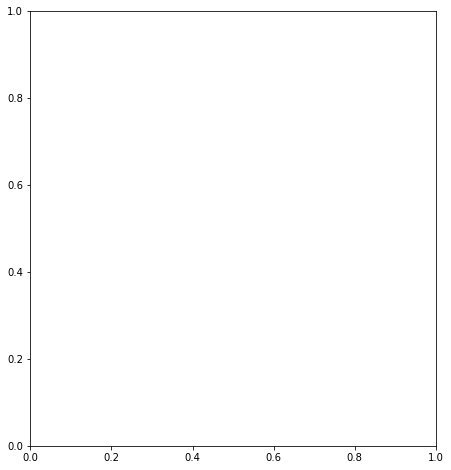

In [10]:
%matplotlib inline
fig = plt.figure(figsize = (16,8))

T0, T1 = np.meshgrid(np.linspace(-10,10,100),np.linspace(-10, 10,100))

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(T0, T1, Z, 70, cmap = 'jet')
#ax.quiver(beta_0[:-1], beta_1[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .9)
#ax.set_xlabel('beta 0')
#ax.set_ylabel('beta 1')
#ax.legend()

plt.legend()
plt.show()

In [13]:
def costfunction(X,y,theta):
    #Initialisation of useful values 
    m = np.size(y)
    
    #Cost function in vectorized form
    h = X @ theta
    J = float((1./(2*m)) * (h - y).T @ (h - y));    
    return J;


def coordinate_descent(theta,X,y,alpha = .03, num_iters=20):
    '''Coordinate gradient descent for linear regression'''
    #Initialisation of useful values 
    m,n = X.shape
    J_history = []
    theta_0_hist, theta_1_hist = [], [] #For plotting afterwards
    
    
    for i in range(num_iters):
        
        for j in range(n):
            #Coordinate descent in vectorized form
            h = X @ theta 
            gradient =  (X[:,j] @ (h-y))
            theta[j] = theta[j] - alpha * gradient
            
            #Saving values for plots
            J_history.append(costfunction(X,y,theta))
            theta_0_hist.append(theta[0,0])
            theta_1_hist.append(theta[1,0])
                       
    return theta ,J_history, theta_0_hist, theta_1_hist

def coordinate_descent_norm(theta,X,y,alpha = .03, num_iters=100):
    '''Coordinate gradient descent for linear regression - for normalized data'''
    #Initialisation of useful values 
    m,n = X.shape
    X = X / (np.linalg.norm(X,axis = 0)) #normalizing X
    J_history = []
    theta_0_hist, theta_1_hist = [], [] #For plotting afterwards
    
    
    for i in range(num_iters):
        
        for j in range(n):
            #Coordinate descent in vectorized form
            h = (X[:,0:j] @ theta[0:j]) + (X[:,j+1:] @ theta[j+1:])
            theta[j] =  (X[:,j] @ (y - h))
            
            #Saving values for plots
            J_history.append(costfunction(X,y,theta))
            theta_0_hist.append(theta[0,0])
            theta_1_hist.append(theta[1,0])
                       
    return theta ,J_history, theta_0_hist, theta_1_hist

In [14]:
#Creating the dataset (as previously)
x = np.linspace(0,1,40)
noise = 1*np.random.uniform(  size = 40)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = (y + noise).reshape(-1,1)
y_noise = y_noise - y_noise.mean()
X = np.vstack((2*x,x**2)).T
initial_theta = np.array([4,-4.]).reshape(-1,1)

#Setup of meshgrid of theta values
T0, T1 = np.meshgrid(np.linspace(0,3,100),np.linspace(-5.5,-3,100))

#Computing the cost function for each theta combination
zs = np.array(  [costfunction(X, y_noise.reshape(-1,1),np.array([t0,t1]).reshape(-1,1)) 
                     for t0, t1 in zip(np.ravel(T0), np.ravel(T1)) ] )
#Reshaping the cost values    
Z = zs.reshape(T0.shape)

In [18]:
#Computing the gradient descent
theta_result_c,J_history_c, theta_0_c, theta_1_c = coordinate_descent(initial_theta,X,y_noise, alpha = .009) 

#Angles needed for quiver plot
anglesx = np.array(theta_0_c)[1:] - np.array(theta_0_c)[:-1]
anglesy = np.array(theta_1_c)[1:] - np.array(theta_1_c)[:-1]

In [33]:
len(J_history_c)

40

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(T0, T1, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
ax.plot(theta_0_c,theta_1_c,J_history_c, marker = '*', color = 'r', alpha = .4, label = 'Gradient descent')

ax.set_xlabel('theta 0')
ax.set_ylabel('theta 1')
ax.set_zlabel('Cost function')
ax.set_title('Gradient descent: Root at {}'.format(theta_result_c.ravel()))
ax.view_init(45, -75)
ax.legend()


#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(T0, T1, Z, 70, cmap = 'jet')
ax.quiver(theta_0_c[:-1], theta_1_c[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .9)
ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
ax.set_title('Gradient descent: Root at {}'.format(theta_result_c.ravel()))
ax.legend()

plt.legend()
plt.show()

### coordinate descent - implementation for linear regression

* at each iteration, the algorithm determines a coordinate, then minimizes over the corresponding hyperplane while fixing all other coordinates.